In [3]:
import os
import sys
import json
import numpy as np
import time
import cv2
import skimage
from PIL import Image, ImageDraw
from imgaug import augmenters as iaa
from imgaug.augmentables.segmaps import SegmentationMapOnImage
import csv
%matplotlib inline

In [4]:
# Set the ROOT_DIR variable to the root directory of the Mask_RCNN git repo
ROOT_DIR = 'C:/Users/alexi/Detecteur_nageur'
assert os.path.exists(ROOT_DIR), 'ROOT_DIR does not exist. Did you forget to read the instructions above? ;)'

# Import mrcnn libraries
sys.path.append(ROOT_DIR) 
from mrcnn.config import Config
import mrcnn.utils as utils
from mrcnn import visualize
import mrcnn.model as modellib

In [5]:
# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

In [6]:
#Transforme une vidéos en série d'image.
#DIRECTORY où les vidéos sont enregistrées (Constante)
VIDEO_DIR = 'C:/Users/alexi/Detecteur_nageur/videos/'
#DIRECTORY où les images seront sauvegardées
IMG_DIR = 'C:/Users/alexi/Detecteur_nageur/images/'
#Nom de la video (variable)
video_file = '100 NL d Gwandju.MP4'

savePathFolder = IMG_DIR+video_file[:-4]

FOLDER_IMAGE = savePathFolder

dirs = os.listdir(IMG_DIR)

if(video_file[:-4]) in dirs:        
    if not os.path.isdir(savePathFolder):
        try:
            os.mkdir(savePathFolder)
        except:
            print("cant create folder")
else:
    try:
        os.mkdir(savePathFolder)
    except:
        print("cant create folder")
        

capture = cv2.VideoCapture(VIDEO_DIR+video_file)
success,image = capture.read()
count = 0

while success:
  cv2.imwrite(savePathFolder+"/frame%d.jpg" % count, image) 
  success,image = capture.read()
  count += 1

print('save de %d images' %count)

save de 1632 images


In [7]:
class NageursConfig(Config):
    """Configuration pour un entrainement fait sur les nageurs.
    Model ispiré de l'original mais adapté à mon GPU
    """
    NAME = "nageur"

    # Le nombre d'image par GPU dépend de la capacité en mémoire
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    # Nombre de classes
    NUM_CLASSES = 1 + 1  # background + 1 (nageur)

    # Shap
    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 512

    #depend de la mémoire
    STEPS_PER_EPOCH = 500

    # This is how often validation is run.
    VALIDATION_STEPS = 5
    
    # Peut être modifié si on souhaite utiliser un autre backbone
    BACKBONE = 'resnet50'

    # Configuration du RPN
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)
    TRAIN_ROIS_PER_IMAGE = 32
    MAX_GT_INSTANCES = 50 
    POST_NMS_ROIS_INFERENCE = 500 
    POST_NMS_ROIS_TRAINING = 1000 
    
config = NageursConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE              

In [8]:
class InferenceConfig(NageursConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 512
    DETECTION_MIN_CONFIDENCE = 0.95
    

inference_config = InferenceConfig()

In [9]:
# mode détection
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Instructions for updating:
Use fn_output_signature instead


In [10]:
#get path pour le dernier entrainement
model_path = model.find_last()

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  C:/Users/alexi/Detecteur_nageur\logs\nageur20210819T2141\mask_rcnn_nageur_0030.h5
Re-starting from epoch 30


In [11]:
class CocoLikeDataset(utils.Dataset):
    """ Generates a COCO-like dataset, i.e. an image dataset annotated in the style of the COCO dataset.
        See http://cocodataset.org/#home for more information.
    """
    def load_data(self, annotation_json, images_dir):
        """ Load the coco-like dataset from json
        Args:
            annotation_json: The path to the coco annotations json file
            images_dir: The directory holding the images referred to by the json file
        """
        # Load json from file
        json_file = open(annotation_json)
        coco_json = json.load(json_file)
        json_file.close()
        
        # Add the class names using the base method from utils.Dataset
        source_name = "coco_like"
        for category in coco_json['categories']:
            class_id = category['id']
            class_name = category['name']
            #if class_id < 1:
            #    print('Error: Class id for "{}" cannot be less than one. (0 is reserved for the background)'.format(class_name))
            #    return
            
            self.add_class(source_name, class_id, class_name)
        
        # Get all annotations
        annotations = {}
        for annotation in coco_json['annotations']:
            image_id = annotation['image_id']
            if image_id not in annotations:
                annotations[image_id] = []
            annotations[image_id].append(annotation)
        
        # Get all images and add them to the dataset
        seen_images = {}
        for image in coco_json['images']:
            image_id = image['id']
            print (image_id)
            if image_id in seen_images:
                print("Warning: Skipping duplicate image id: {}".format(image))
            else:
                seen_images[image_id] = image
                try:
                    image_file_name = image['file_name']
                    print (image_file_name)
                    image_width = image['width']
                    image_height = image['height']
                except KeyError as key:
                    print("Warning: Skipping image (id: {}) with missing key: {}".format(image_id, key))
                
                image_path = os.path.abspath(os.path.join(images_dir, image_file_name))
                image_annotations = annotations[image_id]
                
                # Add the image using the base method from utils.Dataset
                self.add_image(
                    source=source_name,
                    image_id=image_id,
                    path=image_path,
                    width=image_width,
                    height=image_height,
                    annotations=image_annotations
                )
                
    def load_mask(self, image_id):
        """ Load instance masks for the given image.
        MaskRCNN expects masks in the form of a bitmap [height, width, instances].
        Args:
            image_id: The id of the image to load masks for
        Returns:
            masks: A bool array of shape [height, width, instance count] with
                one mask per instance.
            class_ids: a 1D array of class IDs of the instance masks.
        """
        image_info = self.image_info[image_id]
        annotations = image_info['annotations']
        instance_masks = []
        class_ids = []
        
        for annotation in annotations:
            class_id = annotation['category_id']
            mask = Image.new('1', (image_info['width'], image_info['height']))
            mask_draw = ImageDraw.ImageDraw(mask, '1')
            for segmentation in annotation['segmentation']:
                mask_draw.polygon(segmentation, fill=1)
                bool_array = np.array(mask) > 0
                instance_masks.append(bool_array)
                class_ids.append(class_id)

        mask = np.dstack(instance_masks)
        class_ids = np.array(class_ids, dtype=np.int32)
        
        return mask, class_ids

In [12]:
dataset_val = CocoLikeDataset()
dataset_val.load_data('C:/Users/alexi/Detecteur_nageur/datasets/nageur/val/coco_annotations.json', 'C:/Users/alexi/Detecteur_nageur/datasets/nageur/val/images')
dataset_val.prepare()

0
femmeNlAngers (22).jpg
1
femmeNlAngers (29).jpg
2
femmeNlAngers (30).jpg
3
femmeNlAngers (31).jpg
4
femmeNlAngers (32).jpg
5
femmeNlAngers (33).jpg
6
femmeNlAngers (34).jpg
7
femmeNlAngers (35).jpg
8
femmeNlAngers (36).jpg
9
femmeNlAngers (37).jpg
10
femmeNlAngers (38).jpg
11
femmeNlAngers (39).jpg
12
femmeNlAngers (40).jpg
13
femmeNlAngers (41).jpg
14
femmeNlAngers (42).jpg
15
femmeNlAngers (43).jpg
16
femmeNlAngers (44).jpg
17
femmeNlAngers (45).jpg
18
femmeNlAngers (46).jpg
19
femmeNlAngers (47).jpg
20
femmeNlAngers (48).jpg
21
femmeNlAngers (49).jpg
22
femmeNlAngers (50).jpg
23
femmeNlAngers (51).jpg
24
femmeNlAngers (52).jpg
25
femmeNlAngers (53).jpg
26
femmeNlAngers (54).jpg
27
nlDameCol (1).jpg
28
nlDameCol (10).jpg
29
nlDameCol (100).jpg
30
nlDameCol (101).jpg
31
nlDameCol (102).jpg
32
nlDameCol (103).jpg
33
nlDameCol (104).jpg
34
nlDameCol (105).jpg
35
nlDameCol (106).jpg
36
nlDameCol (107).jpg
37
nlDameCol (108).jpg
38
nlDameCol (109).jpg
39
nlDameCol (11).jpg
40
nlDameCol 

In [13]:
#range les boundings boxes par absisses décroissantes
def TriNageurs (boxes) :
    nageurs = []
    N = boxes.shape[0]
    
    for i in range(0,N):
            y1, x1, y2, x2 = boxes[i]            
            nageurs.append([y1, x1, y2, x2])
    nageursOrdo = []
    yMmax = nageurs[0][0]
    jMax = 0   
    
    for i in range(0,N):        
        yMax = nageurs[0][0]
        jMax = 0
        
        for j in range (0,(N-i)):            
            if (nageurs[j][0] > yMax):
                yMax = nageurs[j][0]
                jMax = j
                
        y1, x1, y2, x2 = nageurs[jMax]        
        nageursOrdo.append([y1, x1, y2, x2])
        nageurs.pop(jMax)
        
    return nageursOrdo

Processing 1 images
image                    shape: (720, 1280, 3)        min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1280.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


C:\Users\alexi\.conda\envs\mask-rcnn\lib\site-packages\tensorflow\python\keras\engine\training.py:2426: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


C:/Users/alexi/Detecteur_nageur/images/100 NL d Gwandju/frame0


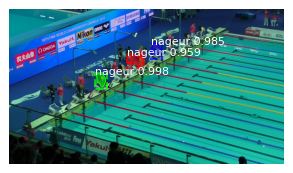

0
[[299, 400, 374, 456], [211, 550, 272, 628], [159, 658, 233, 709]]
Processing 1 images
image                    shape: (720, 1280, 3)        min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1280.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32
C:/Users/alexi/Detecteur_nageur/images/100 NL d Gwandju/frame1


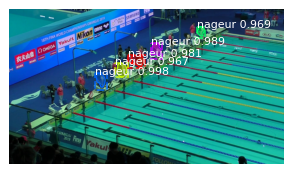

1
[[299, 398, 375, 454], [252, 494, 318, 552], [212, 552, 272, 630], [158, 658, 234, 711], [81, 874, 136, 913]]
Processing 1 images
image                    shape: (720, 1280, 3)        min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1280.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32
C:/Users/alexi/Detecteur_nageur/images/100 NL d Gwandju/frame2


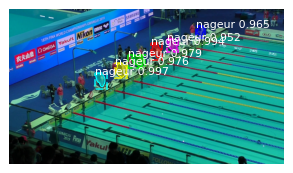

2
[[297, 399, 371, 453], [251, 491, 319, 550], [213, 555, 273, 631], [160, 658, 236, 712], [140, 734, 201, 784], [80, 872, 134, 912]]
Processing 1 images
image                    shape: (720, 1280, 3)        min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1280.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32
C:/Users/alexi/Detecteur_nageur/images/100 NL d Gwandju/frame3


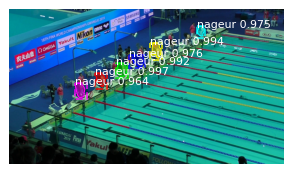

3
[[346, 307, 421, 362], [298, 399, 370, 456], [250, 497, 319, 552], [213, 557, 272, 631], [157, 657, 237, 713], [80, 874, 135, 913]]
Processing 1 images
image                    shape: (720, 1280, 3)        min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1280.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32
C:/Users/alexi/Detecteur_nageur/images/100 NL d Gwandju/frame4


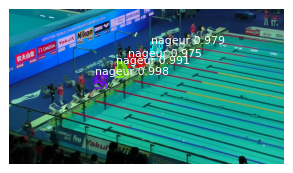

4
[[299, 397, 366, 455], [245, 498, 318, 553], [212, 554, 271, 631], [154, 658, 234, 710]]
Processing 1 images
image                    shape: (720, 1280, 3)        min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1280.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32
C:/Users/alexi/Detecteur_nageur/images/100 NL d Gwandju/frame5


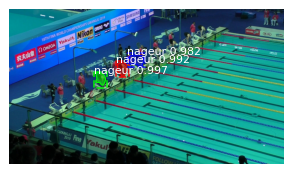

5
[[295, 396, 366, 453], [242, 499, 314, 556], [205, 548, 269, 631]]
Processing 1 images
image                    shape: (720, 1280, 3)        min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1280.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32
C:/Users/alexi/Detecteur_nageur/images/100 NL d Gwandju/frame6


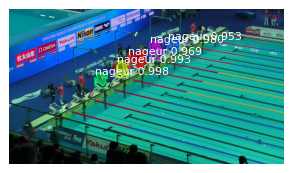

6
[[299, 397, 367, 455], [242, 501, 314, 555], [206, 552, 268, 632], [150, 655, 233, 714], [135, 739, 196, 787]]
Processing 1 images
image                    shape: (720, 1280, 3)        min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1280.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32
C:/Users/alexi/Detecteur_nageur/images/100 NL d Gwandju/frame7


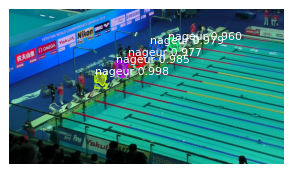

7
[[298, 398, 369, 452], [242, 497, 315, 556], [208, 553, 268, 634], [154, 656, 232, 713], [134, 740, 197, 787]]
Processing 1 images
image                    shape: (720, 1280, 3)        min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1280.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32
C:/Users/alexi/Detecteur_nageur/images/100 NL d Gwandju/frame8


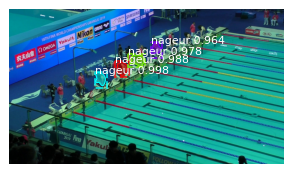

8
[[295, 397, 369, 453], [242, 494, 314, 558], [207, 551, 269, 634], [154, 658, 230, 710]]
Processing 1 images
image                    shape: (720, 1280, 3)        min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1280.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32
C:/Users/alexi/Detecteur_nageur/images/100 NL d Gwandju/frame9


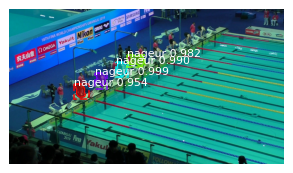

9
[[348, 302, 419, 370], [296, 397, 371, 454], [245, 497, 316, 555], [212, 550, 269, 634]]
Processing 1 images
image                    shape: (720, 1280, 3)        min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1280.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32
C:/Users/alexi/Detecteur_nageur/images/100 NL d Gwandju/frame10


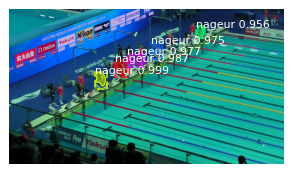

10
[[295, 398, 370, 453], [238, 493, 314, 559], [207, 548, 269, 633], [152, 658, 232, 710], [78, 872, 133, 912]]
Processing 1 images
image                    shape: (720, 1280, 3)        min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1280.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32
C:/Users/alexi/Detecteur_nageur/images/100 NL d Gwandju/frame11


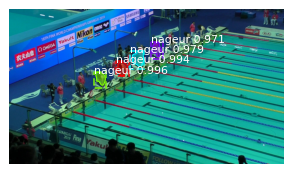

11
[[293, 395, 367, 450], [241, 496, 313, 559], [194, 560, 277, 629], [151, 661, 232, 714]]
Processing 1 images
image                    shape: (720, 1280, 3)        min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1280.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32
C:/Users/alexi/Detecteur_nageur/images/100 NL d Gwandju/frame12


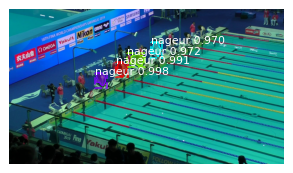

12
[[296, 397, 368, 454], [245, 497, 317, 555], [205, 549, 269, 634], [154, 660, 230, 711]]
Processing 1 images
image                    shape: (720, 1280, 3)        min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1280.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32
C:/Users/alexi/Detecteur_nageur/images/100 NL d Gwandju/frame13


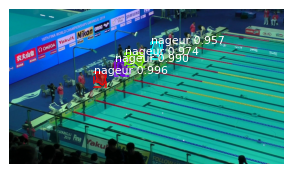

13
[[295, 395, 362, 452], [236, 494, 311, 560], [204, 541, 271, 629], [153, 661, 231, 710]]
Processing 1 images
image                    shape: (720, 1280, 3)        min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1280.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32
C:/Users/alexi/Detecteur_nageur/images/100 NL d Gwandju/frame14


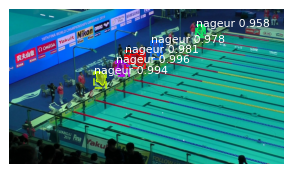

14
[[291, 396, 368, 449], [240, 496, 311, 559], [195, 539, 276, 630], [147, 661, 231, 712], [74, 872, 129, 910]]
Processing 1 images
image                    shape: (720, 1280, 3)        min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1280.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32
C:/Users/alexi/Detecteur_nageur/images/100 NL d Gwandju/frame15


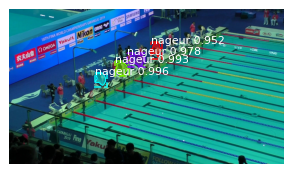

15
[[296, 397, 363, 454], [242, 492, 311, 557], [203, 547, 269, 631], [154, 661, 232, 711]]
Processing 1 images
image                    shape: (720, 1280, 3)        min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1280.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32
C:/Users/alexi/Detecteur_nageur/images/100 NL d Gwandju/frame16


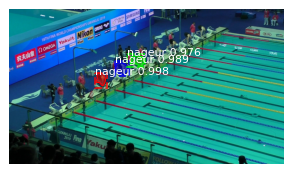

16
[[297, 399, 368, 453], [241, 491, 312, 556], [211, 550, 269, 633]]
Processing 1 images
image                    shape: (720, 1280, 3)        min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1280.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32
C:/Users/alexi/Detecteur_nageur/images/100 NL d Gwandju/frame17


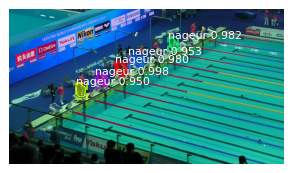

17
[[343, 310, 418, 361], [299, 399, 368, 457], [242, 494, 314, 555], [207, 553, 270, 633], [132, 740, 197, 788]]
Processing 1 images
image                    shape: (720, 1280, 3)        min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1280.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32
C:/Users/alexi/Detecteur_nageur/images/100 NL d Gwandju/frame18


KeyboardInterrupt: 

In [14]:
#Parcours de l'ensemble des images générés depuis la vidéo
real_test_dir = FOLDER_IMAGE
#Tableau contenant toutes les ROIs pour chaque image
fullPos = [[],[]]
files = os.listdir(real_test_dir)
MAX = len(files)
MAX = MAX - int(MAX/10)
frame = 0
for i in range(0, MAX):
    if i%1 == 0:
        if('frame%d.jpg'%i) in files:
            img = skimage.io.imread(real_test_dir+'/'+'frame%d.jpg'%i)
            img_arr = np.array(img)
            results = model.detect([img_arr], verbose=1)
            r = results[0]
            boxes = r['rois']
            N = boxes.shape[0]

            #display_images(np.transpose(activations["res2c_out"][0,:,:,:4], [2, 0, 1]), cols=4)


            if N > 0:
                print(real_test_dir+'/'+'frame%d'%i)
                visualize.display_instances(img, r['rois'], r['masks'], r['class_ids'], 
                                        dataset_val.class_names, r['scores'], figsize=(5,5))
                print(frame)        
                nageursTries = TriNageurs(boxes)
                print(nageursTries)
                #saveImage(nageursTries,N,img,frame)
                fullPos[0].append(nageursTries)
                fullPos[1].append(frame)
            frame = frame +1

In [ ]:
#Fonction initiant le tracking, cherche des positions pour lesquels on a autant de boundings boxes que de nageurs,
#et des boundings boxes qui se suivent d'une frame à l'autre.
#(on cherche au niveau de la prochaine frame qui à le bon nombre de boundings boxes)
#Renvoi un tableau contenant le début des positions pour un nageur
def SuiviNageur(idNageur, fullPos, posNageur = [[],[]], start = 0):
    count = 0
    delta = 0
    print ('teste à '+str(start))
    for i in range (start, len(fullPos[0])):
        if count < 3: 
            if len(fullPos[0][i]) == 8: 
                k = 1
                count_max = len(fullPos[0]) - i
                for j in range(1, count_max):
                    if len(fullPos[0][i+k]) == 8: 
                        #print ('i :'+str(i))
                        #print('k'+str(i+k))
                        y_a =  fullPos[0][i][idNageur][2]
                        y_b =  fullPos[0][i+k][idNageur][2]
                        x_a =  fullPos[0][i][idNageur][3]
                        x_b =  fullPos[0][i+k][idNageur][3]
                        dist = abs(x_a-x_b)+abs(y_a-y_b)
                        #print(dist)
                        break
                    else:
                        k+=1
                        dist = 1000                        
                if dist < 25+5*k:
                    count += 1
                    if count == 2:
                        delta = i                        
                else:                    
                    delta = 0
                    count = 0
                    #print('r à z : '+str(i))
                    #print("d = "+str(dist))
        else:
            print('reprise à' +str(delta))
            #print(i-1)
            posNageur[0].append(fullPos[0][delta][idNageur])
            posNageur[1].append(fullPos[1][delta])  
            posNageur[0].append(fullPos[0][i-1][idNageur])
            posNageur[1].append(fullPos[1][i-1])
            break
    return posNageur
                

    

In [ ]:
#Récupère le début des positions d'un nageur et le complete pour chaque frame grâce au tableau contenant toutes les positions.
def CompleteNageurPos(posNageur, fullPos, idNageur):
    idStart = posNageur[1][-1]+1
    y_a = posNageur[0][-1][2]
    k = 1
    nageur_perdu = False
    #print(y_a)
    for i in range(len(fullPos[0])):

        if fullPos[1][i]>idStart and nageur_perdu == False:
            distMin = 1000
            jMin = 0
            #si on a créé une position fictive 5 fois de suite, on refait appelle à la fonction d'initialisation pour retrouver la bonne position
            if k%5 == 0:
                posNageur = SuiviNageur(idNageur, fullPos, posNageur,i)
                idStart = posNageur[1][-1]+1
                if idStart == i:
                    nageur_perdu = True                                       
                print('reprise à %d'%idStart)
                y_a = posNageur[0][-1][2]
                k = 1
            else:
                #On associe soit la bounding boxe la plus probable, et si elle n'existe pas, on en créé une en se basant sur les 
                #positions précédentes.
                for j in range(len(fullPos[0][i])):
                    y_b =  fullPos[0][i][j][2]
                    dist = abs(y_a-y_b)
                    if dist < distMin:
                        distMin = dist
                        jMin = j
                if distMin < 30:
                    posNageur[0].append(fullPos[0][i][jMin])
                    posNageur[1].append(fullPos[1][i])                
                    y_a = fullPos[0][i][jMin][2]
                    k=1
                    #print('a la frame '+str(fullPos[1][i])+'ajout de '+str(jMin)+' val '+str(fullPos[0][i][jMin])+'car dMin ='+str(distMin))
                else:
                    print ("données ajoutées "+str(fullPos[1][i])+" car distMin ="+str(distMin))
                    pos1 = posNageur[0][-2]
                    pos2 = posNageur[0][-1]
                    diffPos = [b_elt - a_elt for a_elt, b_elt in zip(pos1, pos2)]
                    newPos = [int((b_elt)/2) + a_elt for a_elt, b_elt in zip(pos2, diffPos)]
                    posNageur[0].append(newPos)
                    posNageur[1].append(fullPos[1][i])
                    k+=1
                    #y_a = newPos[2]
                    #print('new Y ='+str(y_a))

    return posNageur      

In [ ]:
#posNageur.clear()
#posNageur = SuiviNageur(0,fullPos)
#print (posNageur)
#posNageur = CompleteNageurPos(posNageur, fullPos,0)

'''
for i in range(len(posNageur[0])):
    print(posNageur[1][i])    
    print(posNageur[0][i])
    print(fullPos[0][i+16][2])
'''

In [ ]:
#print(posNageur[0][397])

In [ ]:
def ReBuildFullPos (fullPos, nbNageurs):
    newFullPos = []
    for i in range(nbNageurs):
        posNageur = [[],[]]
        posNageur = SuiviNageur(i,fullPos,posNageur)
        posNageur = CompleteNageurPos(posNageur, fullPos,i)
        newFullPos.append(posNageur)
        #posNageur.clear()
    return newFullPos

In [ ]:
newFullPos = ReBuildFullPos (fullPos, 8)
#posNageur = newFullPos[0]
#for i in range (0, 100):
#    print(posNageur[0][i])

In [ ]:
#posNageur = newFullPos[7]
#posNageur1 = newFullPos[2]
#print(posNageur[0])
#for tab in posNageur[0]:
#    for val in tab:
#        if val>1280:
#            print(tab)
#for i in range(1325,1350):
#    print(posNageur0[1][i])
#    print(posNageur0[0][i])
#    print("#####")


In [ ]:
#sauvegarde les positions dans un CSV si on veut les retravailler plus tard ou les garder en mémoire pour ne pas à faire retourner
#le modèle.
def SavePosInCSV (savePathFolder, idNageur, newFullPos):
    posNageur = newFullPos[idNageur]    
    dirs = os.listdir(savePathFolder)
    savePathFolder += "/nageur_"+str(idNageur)
    if("nageur_"+str(idNageur)) in dirs:        
        if not os.path.isdir(savePathFolder):
            try:
                os.mkdir(savePathFolder)
            except:
                print("cant create folder")
    else:
        try:
            os.mkdir(savePathFolder)
        except:
            print("cant create folder")
            
    if os.path.exists(savePathFolder+'/position_nageur_'+str(idNageur)+'.csv'):
        os.remove(savePathFolder+'/position_nageur_'+str(idNageur)+'.csv')
        print('previousFileRemove')

    try:
        with open(savePathFolder+'/position_nageur_'+str(idNageur)+'.csv', 'w', newline="") as f:
            write = csv.writer(f)
            fields = ['frame','x1','x2','y1','y2']
            write.writerow(fields)    

            for i in range(len(posNageur[0])):
                row = []
                row.append(posNageur[1][i])
                row.append(posNageur[0][i][1])
                row.append(posNageur[0][i][3])
                row.append(posNageur[0][i][0])
                row.append(posNageur[0][i][2])
                write.writerow(row)
    except:
        print("error")
            

In [ ]:
savePathFolder = 'C:/Users/alexi/mask_rcnn/datasets/zoom_nageur/100 NL d Gwandju'
nbNageurs = 8
#savePosInCSV(savePathFolder,0,newFullPos)

In [ ]:
def SaveAllPos(savePathFolder,newFullPos,nbNageurs):
    for i in range(nbNageurs):
        SavePosInCSV(savePathFolder,i,newFullPos)

In [ ]:
SaveAllPos(savePathFolder,newFullPos,nbNageurs)

In [ ]:
def showPoseImage(newFullPos, i, nbNageurs, img, idFrame, savePathFolder):
    for idNageur in range (nbNageurs):
        y1, x1, y2, x2 = newFullPos[idNageur][0][i]
        cv2.rectangle(img,(x1,y1),(x2,y2),(0,255,0),3)
        pathSave = savePathFolder+'/ROI_'+str(idFrame)+'.jpg'
    cv2.imwrite(pathSave, cv2.cvtColor(img, cv2.COLOR_RGB2BGR))        
    cv2.waitKey(0)

In [ ]:
def saveImage(pos, idNageur, img, idFrame, savePathFolder) :
    savePathFolder += '/nageur_'+str(idNageur)
    y1, x1, y2, x2 = pos
    if y1 < 0:
        y1=0
    if x1 < 0:
        x1=0
    print(idFrame)
    print (pos)

    l = x2 - x1

    if (y1 > 30):
        y1 = y1 - 30

    y2 = y2 +30

    if (x1 > 30):
        x1 = x1 - 30

    x2 = x2 + 30

    imgCrop = img[(y1):(y2),(x1):(x2)]
    #image = cv2.resize(imgCrop,(400,200))
    pathSave = savePathFolder+'/crop_'+str(idFrame)+'.jpg'
    #cv2.imwrite(pathSave, cv2.cvtColor(image, cv2.COLOR_RGB2BGR)) 
    cv2.imwrite(pathSave, cv2.cvtColor(imgCrop, cv2.COLOR_RGB2BGR))        
    cv2.waitKey(0)

In [ ]:
real_test_dir = FOLDER_IMAGE
nbNageurs = 8
image_paths = []
files = os.listdir(real_test_dir)
savePathFolderROI = 'C:/Users/alexi/mask_rcnn/datasets/ROI'

for idNageur in range(nbNageurs):
    print("ajout Frame Nageur %d"%idNageur)
    for idFrame in newFullPos[idNageur][1]:
        i = newFullPos[idNageur][1].index(idFrame)
        pos = newFullPos[idNageur][0][i]      
        if('frame%d.jpg'%idFrame) in files:          
            img = skimage.io.imread(real_test_dir+'/'+'frame%d.jpg'%idFrame)
            saveImage(pos, idNageur, img, idFrame, savePathFolder)
            showPoseImage(newFullPos, i, nbNageurs, img, idFrame, savePathFolderROI)
    

In [ ]:
#Fonctions de créations de vidéos pour la démo.
video_path = 'C:/Users/alexi/mask_rcnn/datasets/zoom_nageur/100 NL d Gwandju/nageur_1/'
width = 260
height = 80
size = (width,height)
out = cv2.VideoWriter('C:/Users/alexi/mask_rcnn/datasets/zoom_nageur/100 NL d Gwandju/nageur_1/zoom.avi',cv2.VideoWriter_fourcc(*'DIVX'), 15, size)
files = os.listdir(video_path)

for i in range(0,1500):
    if ('crop_'+str(i)+'.jpg') in files :
        img=cv2.resize(cv2.imread(video_path+'crop_'+str(i)+'.jpg'),(width, height))
        out.write(img)
out.release()



In [ ]:
video_path = 'C:/Users/alexi/mask_rcnn/datasets/ROI/'
width = 1280
height = 720
size = (width,height)
out = cv2.VideoWriter('C:/Users/alexi/mask_rcnn/datasets/ROI/ROIs.avi',cv2.VideoWriter_fourcc(*'DIVX'), 30, size)
files = os.listdir(video_path)

for i in range(0,1500):
    if ('ROI_'+str(i)+'.jpg') in files :
        img=cv2.resize(cv2.imread(video_path+'ROI_'+str(i)+'.jpg'),(width, height))
        out.write(img)
out.release()
